<a href="https://colab.research.google.com/github/AkHiLdEvGoD/Transformer-NMT/blob/main/NMT_Transformer_Training_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datasets import load_dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = load_dataset("Aarif1430/english-to-hindi")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-71c2cec7402cd4(…):   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127705 [00:00<?, ? examples/s]

In [ ]:
import math
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors, normalizers
from tokenizers.normalizers import NFKC, Lowercase, StripAccents, Sequence
import unicodedata
from tokenizers.pre_tokenizers import Whitespace
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

In [ ]:
train_data = dataset['train']
print(train_data[0])

{'english_sentence': "However, Paes, who was partnering Australia's Paul Hanley, could only go as far as the quarterfinals where they lost to Bhupathi and Knowles", 'hindi_sentence': 'आस्ट्रेलिया के पाल हेनली के साथ जोड़ी बनाने वाले पेस मियामी में क्वार्टरफाइनल तक ही पहुंच सके क्योंकि इस दौर में उन्हें भूपति और नोल्स ने हराया था।'}


In [ ]:
df = pd.DataFrame(train_data)
df.head()

,english_sentence,hindi_sentence
0,"However, Paes, who was partnering Australia's ...",आस्ट्रेलिया के पाल हेनली के साथ जोड़ी बनाने वाल...
1,"Whosoever desires the reward of the world, wit...",और जो शख्स (अपने आमाल का) बदला दुनिया ही में च...
2,The value of insects in the biosphere is enorm...,"जैव-मंडल में कीड़ों का मूल्य बहुत है, क्योंकि ..."
3,Mithali To Anchor Indian Team Against Australi...,आस्ट्रेलिया के खिलाफ वनडे टीम की कमान मिताली को
4,After the assent of the Honble President on 8t...,"8 सितम्‍बर, 2016 को माननीय राष्‍ट्रपति की स्‍व..."


In [ ]:
df = df.rename(columns={'english_sentence':'en','hindi_sentence':'hi'})
df = df.dropna(subset=['en','hi'])

In [ ]:
df = df.drop_duplicates(subset=['en', 'hi'])

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Normalize Unicode (removes irregular forms and zero-width joiners)
    text = unicodedata.normalize('NFKC', text)
    text = text.replace('\u200d', '')  # remove zero-width joiner
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['en'] = df['en'].apply(clean_text)
df['hi'] = df['hi'].apply(clean_text)

In [ ]:
df.iloc[4,:].tolist()

['After the assent of the Honble President on 8thSeptember, 2016, the 101thConstitutional Amendment Act, 2016 came into existence',
 '8 सितम्बर, 2016 को माननीय राष्ट्रपति की स्वीकृति मिलने के बाद 101वां संविधान संशोधन अधिनियम, 2016 अस्तित्व में आया']

In [ ]:
iqr = df['en'].str.len().quantile(0.75) - df['en'].str.len().quantile(0.25)
outliers_en = df['en'].str.len().quantile(0.75) + (1.5*iqr)

iqr = df['hi'].str.len().quantile(0.75) - df['hi'].str.len().quantile(0.25)
outliers_hi = df['hi'].str.len().quantile(0.75) + (1.5*iqr)

int(outliers_hi)

235

In [ ]:
df = df[(df['en'].str.len() < int(outliers_en))]
df = df[(df['hi'].str.len() < int(outliers_hi))]

In [ ]:
df.shape

(118048, 2)

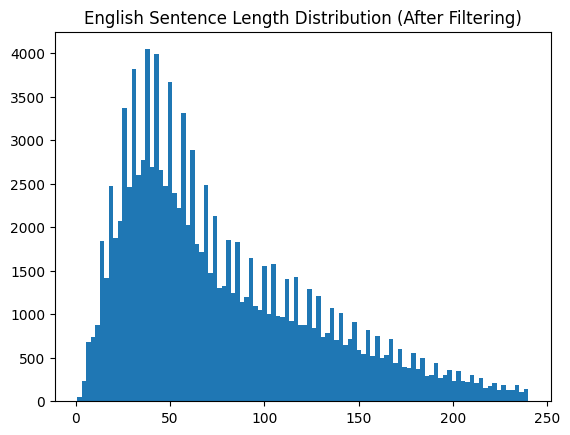

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['en'].str.len(), bins=100)
plt.title("English Sentence Length Distribution (After Filtering)")
plt.show()

In [ ]:
train_df,test_df = train_test_split(df,test_size=0.15,random_state=42,shuffle=True)
print(len(train_df))
print(len(test_df))

100340
17708


## Training Tokenizer on the combined corpus

In [ ]:
train_corpus = train_df['en'].tolist() + train_df['hi'].tolist()

In [ ]:
tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = Sequence([NFKC(), Lowercase(), StripAccents()])
tokenizer.pre_tokenizer = Whitespace()
trainer = trainers.BpeTrainer(
    vocab_size=20000,  # you can adjust between 16k–32k
    min_frequency=2,
    special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"]
)
tokenizer.train_from_iterator(train_corpus, trainer=trainer)
tokenizer.save("bpe_tokenizer.json")
print("✅ Tokenizer training complete and saved!")

✅ Tokenizer training complete and saved!


In [ ]:
tokenizer = Tokenizer.from_file('bpe_tokenizer.json')
sample_en = "After the assent of the Honble President on 8thSeptember, 2016, the 101thConstitutional Amendment Act, 2016 came into existence'"
sample_hi = "8 सितम्\u200dबर, 2016 को माननीय राष्\u200dट्रपति की स्\u200dवीकृति मिलने के बाद 101वां संविधान संशोधन अधिनियम, 2016 अस्तित्\u200dव में आया']"

print("English:", tokenizer.encode(sample_en).tokens)
print("Hindi:", tokenizer.encode(sample_hi).tokens)

English: ['after', 'the', 'assent', 'of', 'the', 'hon', 'ble', 'president', 'on', '8th', 'september', ',', '20', '16', ',', 'the', '101', 'th', 'constitutional', 'amendment', 'act', ',', '20', '16', 'came', 'into', 'existence', "'"]
Hindi: ['8', 'सतमबर', ',', '20', '16', 'क', 'मन', 'नय', 'रषटरपत', 'क', 'सवकत', 'मलन', 'क', 'बद', '101', 'व', 'सवधन', 'सशधन', 'अधनयम', ',', '20', '16', 'असततव', 'म', 'आय', "'", ']']


In [ ]:
sos_id = tokenizer.token_to_id('<sos>')
eos_id = tokenizer.token_to_id('<eos>')
def encode_texts(text,tokenizer):
  return text.apply(lambda x: [sos_id]+tokenizer.encode(x).ids+[eos_id])

In [ ]:
train_df['input_ids'] = encode_texts(train_df['en'],tokenizer)
train_df['target_ids'] = encode_texts(train_df['hi'],tokenizer)

test_df['input_ids'] = encode_texts(test_df['en'],tokenizer)
test_df['target_ids'] = encode_texts(test_df['hi'],tokenizer)

In [ ]:
pad_id = tokenizer.token_to_id('<pad>')
# def pad_sequences(sequences,pad_token=pad_id):
#   return pad_sequence([torch.tensor(seq) for seq in sequences],batch_first=True,padding_value=pad_token)

# train_input_padded = pad_sequences(train_df['input_ids'])
# train_target_padded = pad_sequences(train_df['target_ids'])

# test_input_padded = pad_sequences(test_df['input_ids'])
# test_target_padded = pad_sequences(test_df['target_ids'])

## Creating Dataset and DataLoader

In [ ]:
class TranslationDataset(Dataset):
  def __init__(self,input,target):
    self.input = input
    self.target = target

  def __len__(self):
    return len(self.input)

  def __getitem__(self,idx):
    return torch.tensor(self.input[idx]), torch.tensor(self.target[idx])

In [ ]:
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=pad_id)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=pad_id)
    return src_padded, tgt_padded

In [ ]:
train_dataset = TranslationDataset(train_df['input_ids'].tolist(), train_df['target_ids'].tolist())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)

test_dataset = TranslationDataset(test_df['input_ids'].tolist(), test_df['target_ids'].tolist())
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False,collate_fn=collate_fn,pin_memory=True)

In [ ]:
def create_padding_mask(seq,pad_token_id=pad_id):
  mask = (seq!=pad_token_id).unsqueeze(1).unsqueeze(2)
  return mask.bool()

In [ ]:
def create_causal_mask(seq_len, device):
    mask = torch.tril(torch.ones(seq_len, seq_len, device=device,dtype=torch.bool))
    return mask.unsqueeze(0).unsqueeze(0)

## Transformer Architecture

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self,embd_dims,max_len=5000):
    super().__init__()
    pe = torch.zeros(max_len,embd_dims)
    pos = torch.arange(0,max_len).float().unsqueeze(1)
    den = torch.exp(torch.arange(0,embd_dims,2).float() * -(math.log(10000.0)/embd_dims))
    pe[:,0::2] = torch.sin(pos*den)
    pe[:,1::2] = torch.cos(pos*den)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)

  def forward(self,x):
    return x + self.pe[:,:x.size(1),:]

In [ ]:
def self_attention(q,k,v,padding_mask=None):
  d_k = k.size(-1)
  scores = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
  if padding_mask is not None:
    scores = scores.masked_fill(~padding_mask, float('-inf'))
  weights = torch.softmax(scores,dim=-1)
  weights = torch.nan_to_num(weights, 0.0)
  return torch.matmul(weights,v)

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self,n_heads,d_model):
    super().__init__()
    assert d_model % n_heads == 0
    self.d_head = d_model//n_heads
    self.h = n_heads

    self.W_q = nn.Linear(d_model,d_model)
    self.W_k = nn.Linear(d_model,d_model)
    self.W_v = nn.Linear(d_model,d_model)
    self.final_projection = nn.Linear(d_model,d_model)

  def forward(self,q,k,v,padding_mask=None):
    B,T_q,D = q.size()
    _,T_k,_ = k.size()
    Q = self.W_q(q).view(B,T_q,self.h,self.d_head).transpose(1,2)
    K = self.W_k(k).view(B,T_k,self.h,self.d_head).transpose(1,2)
    V = self.W_v(v).view(B,T_k,self.h,self.d_head).transpose(1,2)

    # if self.mask is True:
    #   x = masked_attention(Q,K,V,padding_mask)
    # else:
    #   x = self_attention(Q,K,V,padding_mask)
    x = self_attention(Q,K,V,padding_mask)

    x = x.transpose(1,2).contiguous().view(B,T_q,D)
    return self.final_projection(x)

In [ ]:
class FeedForward(nn.Module):
  def __init__(self,d_model,d_ff,dropout=0.1):
    super().__init__()
    self.ff = nn.Sequential(
        nn.Linear(d_model,d_ff),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(d_ff,d_model),
        nn.Dropout(dropout)
    )

  def forward(self,x):
    return self.ff(x)

### Encoder

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self,n_heads,d_model,d_ff,dropout=0.1):
    super().__init__()
    self.Attention = MultiHeadAttention(n_heads,d_model)
    self.FeedForward = FeedForward(d_model,d_ff,dropout)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self,x,src_mask):
    z_norm = self.norm1(x + self.dropout(self.Attention(x,x,x,src_mask)))
    y_norm = self.norm2(z_norm + self.dropout(self.FeedForward(z_norm)))
    return y_norm

### Decoder

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self,n_heads,d_model,d_ff,dropout=0.1):
    super().__init__()
    self.masked_attention = MultiHeadAttention(n_heads,d_model)
    self.CrossAttention = MultiHeadAttention(n_heads,d_model)
    self.FeedForward = FeedForward(d_model,d_ff,dropout)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.norm3 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self,x,enc_outs,tgt_mask,src_mask):
    z_norm = self.norm1(x + self.dropout(self.masked_attention(x,x,x,tgt_mask)))
    zc_norm = self.norm2(z_norm + self.dropout(self.CrossAttention(z_norm,enc_outs,enc_outs,src_mask)))
    y_norm =  self.norm3(zc_norm + self.dropout(self.FeedForward(zc_norm)))
    return y_norm

In [ ]:
class Transformer(nn.Module):
  def __init__(self,d_model,n_heads,d_ff,vocab_size,N_enc=6,N_dec=6,dropout=0.1,max_len=5000,padding_idx=pad_id):
    super().__init__()
    self.padding_idx = padding_idx
    self.d_model=d_model
    self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=padding_idx)
    self.pos_encoding = PositionalEncoding(d_model, max_len)
    self.encoder_layers = nn.ModuleList([
                EncoderLayer(n_heads, d_model, d_ff, dropout) for _ in range(N_enc)
            ])
    self.encoder_norm = nn.LayerNorm(d_model)
    self.decoder_layers = nn.ModuleList([
                DecoderLayer(n_heads, d_model, d_ff, dropout) for _ in range(N_dec)
            ])
    self.decoder_norm = nn.LayerNorm(d_model)
    self.projection = nn.Linear(d_model,vocab_size)
    self._init_weights()

  def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

  def encode(self, src, src_mask):
        x = self.embedding(src) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x, src_mask)
        return self.encoder_norm(x)

  def decode(self, tgt, enc_output, tgt_mask, src_mask):
        x = self.embedding(tgt) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)

        for layer in self.decoder_layers:
            x = layer(x, enc_output, tgt_mask, src_mask)

        return self.decoder_norm(x)

  def forward(self, src, tgt):
        src_mask = create_padding_mask(src, self.padding_idx)
        tgt_padding_mask = create_padding_mask(tgt, self.padding_idx)
        tgt_causal_mask = create_causal_mask(tgt.size(1), tgt.device)

        tgt_mask = tgt_padding_mask & tgt_causal_mask

        enc_output = self.encode(src, src_mask)
        dec_output = self.decode(tgt, enc_output, tgt_mask, src_mask)

        logits = self.projection(dec_output)
        return logits

In [ ]:
def get_lr(step, d_model, warmup_steps=4000):
    """Learning rate schedule with warmup"""
    step = max(step, 1)
    return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device, scaler, step):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)

    for batch in progress_bar:
        src, tgt = batch
        src = src.to(device)
        tgt = tgt.to(device)

        # Prepare decoder input and target
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:].contiguous().view(-1)

        # Update learning rate with warmup
        lr = get_lr(step, model.d_model, warmup_steps=4000)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        optimizer.zero_grad()

        # Mixed precision training
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16, enabled=(device.type=='cuda')):
            logits = model(src, tgt_input)
            logits = logits.view(-1, logits.size(-1))
            loss = criterion(logits, tgt_output)

        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        step += 1

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}", "lr": f"{lr:.6f}"})

    return total_loss / len(loader), step

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", leave=False):
            src, tgt = batch
            src = src.to(device)
            tgt = tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:].contiguous().view(-1)

            with torch.autocast(device_type='cuda', dtype=torch.bfloat16, enabled=(device.type=='cuda')):
                logits = model(src, tgt_input)
                logits = logits.view(-1, logits.size(-1))
                loss = criterion(logits, tgt_output)

            total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
def translate_sentence(model, sentence, tokenizer, device, max_len=100):
    """Translate a single sentence using greedy decoding"""
    model.eval()

    with torch.no_grad():
        # Encode source sentence
        src_tokens = tokenizer.encode(sentence).ids
        src = [sos_id] + src_tokens + [eos_id]
        src = torch.LongTensor(src).unsqueeze(0).to(device)

        # Encode source
        src_mask = create_padding_mask(src, pad_id)
        enc_output = model.encode(src, src_mask)

        # Initialize target with <sos>
        tgt_tokens = [sos_id]

        for _ in range(max_len):
            tgt = torch.LongTensor(tgt_tokens).unsqueeze(0).to(device)
            tgt_padding_mask = create_padding_mask(tgt, pad_id)
            tgt_causal_mask = create_causal_mask(tgt.size(1), device)
            tgt_mask = tgt_padding_mask & tgt_causal_mask

            # Decode
            dec_output = model.decode(tgt, enc_output, tgt_mask, src_mask)
            logits = model.projection(dec_output)

            # Get next token
            next_token = logits[:, -1, :].argmax(dim=-1).item()
            tgt_tokens.append(next_token)

            # Stop if <eos> is predicted
            if next_token == eos_id:
                break

        # Decode to text (remove <sos> and <eos>)
        output_tokens = [t for t in tgt_tokens[1:] if t not in [sos_id, eos_id, pad_id]]
        translated = tokenizer.decode(output_tokens)

    return translated

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VOCAB_SIZE = tokenizer.get_vocab_size()
D_MODEL = 512
N_HEADS = 8
D_FF = 2048
N_ENC = 6
N_DEC = 6
DROPOUT = 0.1

EPOCHS = 30
ACCUMULATION_STEPS = 2
model = Transformer(D_MODEL, N_HEADS, D_FF, VOCAB_SIZE,
                    N_enc=N_ENC, N_dec=N_DEC, dropout=DROPOUT).to(DEVICE)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")


Model parameters: 64.64M


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1.0, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id, label_smoothing=0.1)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=='cuda'))

best_val_loss = float('inf')
step = 1

for epoch in range(EPOCHS):
  print(f"\n{'='*60}")
  print(f"Epoch {epoch + 1}/{EPOCHS}")
  print(f"{'='*60}")

  train_loss, step = train_epoch(model, train_loader, optimizer, criterion,
                                       DEVICE, scaler, step)
  val_loss = evaluate(model, test_loader, criterion, DEVICE)

  print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Save best model
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, '/content/drive/MyDrive/best_transformer_nmt.pth')
    print("✅ Saved best model!")

  if (epoch + 1) % 5 == 0:
            test_sentences = [
                "How are you?",
                "I love machine learning.",
                "The weather is nice today."
            ]
            print("\n--- Sample Translations ---")
            for sent in test_sentences:
                translation = translate_sentence(model, sent, tokenizer, DEVICE)
                print(f"EN: {sent}")
                print(f"HI: {translation}\n")

  print("\n✅ Training complete!")

/tmp/ipython-input-947758447.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=='cuda'))



Epoch 1/30


Train Loss: 6.6457 | Val Loss: 5.9173
✅ Saved best model!

✅ Training complete!

Epoch 2/30


Train Loss: 5.7578 | Val Loss: 5.6504
✅ Saved best model!

✅ Training complete!

Epoch 3/30


Train Loss: 5.5766 | Val Loss: 5.5354
✅ Saved best model!

✅ Training complete!

Epoch 4/30


Train Loss: 5.4370 | Val Loss: 5.4173
✅ Saved best model!

✅ Training complete!

Epoch 5/30


Train Loss: 5.3117 | Val Loss: 5.3265
✅ Saved best model!

--- Sample Translations ---
EN: How are you?
HI: कय ह ?

EN: I love machine learning.
HI: म अपन कहनय क सथ

EN: The weather is nice today.
HI: यह बहत धनयवद ।


✅ Training complete!

Epoch 6/30


Train Loss: 5.2006 | Val Loss: 5.2611
✅ Saved best model!

✅ Training complete!

Epoch 7/30


Train Loss: 5.1084 | Val Loss: 5.1946
✅ Saved best model!

✅ Training complete!

Epoch 8/30


Train Loss: 5.0223 | Val Loss: 5.1561
✅ Saved best model!

✅ Training complete!

Epoch 9/30


Train Loss: 4.9426 | Val Loss: 5.0961
✅ Saved best model!

✅ Training complete!

Epoch 10/30


Train Loss: 4.8686 | Val Loss: 5.0544
✅ Saved best model!

--- Sample Translations ---
EN: How are you?
HI: कय ह ?

EN: I love machine learning.
HI: म बहत बहत बहत बहत बहत बहत अचछ ह ।

EN: The weather is nice today.
HI: यह क भ बहत ह महतवपरण ह ।


✅ Training complete!

Epoch 11/30


Train Loss: 4.7981 | Val Loss: 5.0109
✅ Saved best model!

✅ Training complete!

Epoch 12/30


Train Loss: 4.7346 | Val Loss: 4.9855
✅ Saved best model!

✅ Training complete!

Epoch 13/30


Train Loss: 4.6740 | Val Loss: 4.9538
✅ Saved best model!

✅ Training complete!

Epoch 14/30


Train Loss: 4.6188 | Val Loss: 4.9298
✅ Saved best model!

✅ Training complete!

Epoch 15/30


Train Loss: 4.5639 | Val Loss: 4.9044
✅ Saved best model!

--- Sample Translations ---
EN: How are you?
HI: कय आप कय कर सकत ह ?

EN: I love machine learning.
HI: म सखन चहत ह .

EN: The weather is nice today.
HI: यह बहत स अधक लकपरय ह ।


✅ Training complete!

Epoch 16/30


Train Loss: 4.5151 | Val Loss: 4.8843
✅ Saved best model!

✅ Training complete!

Epoch 17/30


Train Loss: 4.4692 | Val Loss: 4.8726
✅ Saved best model!

✅ Training complete!

Epoch 18/30


Training:  40%|███▉      | 624/1568 [05:00<07:11,  2.19it/s, loss=4.7025, lr=0.000268]

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/best_transformer_nmt.pth',map_location=DEVICE)['model_state_dict'])

<All keys matched successfully>

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/best_transformer_nmt.pth',
                          map_location=DEVICE)
print(f"Saved at Epoch: {checkpoint['epoch'] + 1}")
print(f"Val Loss: {checkpoint['val_loss']:.4f}")

Saved at Epoch: 17
Val Loss: 4.8726


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1.0, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id, label_smoothing=0.1)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=='cuda'))

/tmp/ipython-input-1582191148.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=='cuda'))


In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
if 'scaler_state_dict' in checkpoint:
    scaler.load_state_dict(checkpoint['scaler_state_dict'])

In [ ]:
start_epoch = checkpoint['epoch'] + 1
step = checkpoint.get('step', 1)
best_val_loss = checkpoint.get('best_val_loss', checkpoint.get('val_loss', float('inf')))

In [ ]:
step

1

In [ ]:
batches_per_epoch = len(train_loader)
step = checkpoint['epoch'] * batches_per_epoch

print(f"✅ Calculated step: {step}")

✅ Calculated step: 25088


In [ ]:
def get_lr(step, d_model, warmup_steps=4000):
    """Learning rate schedule with warmup"""
    step = max(step, 1)
    return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))

In [ ]:
print("\n" + "="*60)
print(f"RESUMING TRAINING: Epochs {start_epoch} to 30")
print("="*60 + "\n")

TOTAL_EPOCHS = 30

for epoch in range(start_epoch, TOTAL_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{TOTAL_EPOCHS}")
    print(f"{'='*60}")

    train_loss, step = train_epoch(model, train_loader, optimizer, criterion,
                                   DEVICE, scaler, step)
    val_loss = evaluate(model, test_loader, criterion, DEVICE)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save checkpoint to Drive
    checkpoint = {
        'epoch': epoch,
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_val_loss': best_val_loss,
    }

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint['best_val_loss'] = best_val_loss
        torch.save(checkpoint, f'/content/drive/MyDrive/best_transformer_nmt.pth')
        print("✅ Saved best model!")

    # Test translations every 5 epochs
    if (epoch + 1) % 5 == 0:
        test_sentences = [
            "How are you?",
            "I love machine learning.",
            "The weather is nice today."
        ]
        print("\n--- Sample Translations ---")
        for sent in test_sentences:
            translation = translate_sentence(model, sent, tokenizer, DEVICE)
            print(f"EN: {sent}")
            print(f"HI: {translation}\n")

print("\n✅ Training complete!")
print(f"🎉 Final Best Validation Loss: {best_val_loss:.4f}")


RESUMING TRAINING: Epochs 17 to 30


Epoch 18/30


Train Loss: 4.4338 | Val Loss: 4.8584
✅ Saved best model!

Epoch 19/30


Train Loss: 4.3930 | Val Loss: 4.8346
✅ Saved best model!

Epoch 20/30


Train Loss: 4.3563 | Val Loss: 4.8267
✅ Saved best model!

--- Sample Translations ---
EN: How are you?
HI: कय आप कस कर सकत ह ?

EN: I love machine learning.
HI: मशन क लए .

EN: The weather is nice today.
HI: यह वशव क सबस बड खलड ह ।


Epoch 21/30


Train Loss: 4.3194 | Val Loss: 4.8021
✅ Saved best model!

Epoch 22/30


Train Loss: 4.2853 | Val Loss: 4.8059

Epoch 23/30


Train Loss: 4.2550 | Val Loss: 4.7963
✅ Saved best model!

Epoch 24/30


Train Loss: 4.2221 | Val Loss: 4.7896
✅ Saved best model!

Epoch 25/30


Train Loss: 4.1947 | Val Loss: 4.7826
✅ Saved best model!

--- Sample Translations ---
EN: How are you?
HI: आप कस करत ह ?

EN: I love machine learning.
HI: हम मशन क उपयग कर सकत ह ।

EN: The weather is nice today.
HI: दश क सबस बड ह ।


Epoch 26/30


Train Loss: 4.1665 | Val Loss: 4.7844

Epoch 27/30


Train Loss: 4.1402 | Val Loss: 4.7714
✅ Saved best model!

Epoch 28/30


Train Loss: 4.1135 | Val Loss: 4.7719

Epoch 29/30


Train Loss: 4.0897 | Val Loss: 4.7601
✅ Saved best model!

Epoch 30/30


Train Loss: 4.0668 | Val Loss: 4.7543
✅ Saved best model!

--- Sample Translations ---
EN: How are you?
HI: कय आप कस करत ह ?

EN: I love machine learning.
HI: म चहत ह क मशन सखन चहत ह ।

EN: The weather is nice today.
HI: इटरनट पर .


✅ Training complete!
🎉 Final Best Validation Loss: 4.7543


In [ ]:
test_sentences = [
                "How are you?",
                "Thank you",
                "Each Veda has four parts.",
                "I will to tell you something",
                "He blames the Government for the delay in securing infrastructure during the first three months : “ We began hearing only in July .",
                "I'll explain a little bit about how it works."
            ]
print("\n--- Sample Translations ---")
for sent in test_sentences:
  translation = translate_sentence(model, sent, tokenizer, DEVICE)
  print(f"EN: {sent}")
  print(f"HI: {translation}\n")


--- Sample Translations ---
EN: How are you?
HI: कय आप कस करत ह ?

EN: Thank you
HI: धनयवद

EN: Each Veda has four parts.
HI: हर वद म चर भग ह -

EN: I will to tell you something
HI: म आपक बतन चहत ह

EN: He blames the Government for the delay in securing infrastructure during the first three months : “ We began hearing only in July .
HI: सरकर न यह बत दय क उसन एक सल क वद क हथ म ह , जब तक क सरकर न सरकर क खलफ एक सबत ह गय .

EN: I'll explain a little bit about how it works.
HI: म आपक कछ ऐस करन चहत ह ।

